In [1]:
# Raw Package
import numpy as np
import pandas as pd
import os
from ppo_torch_copy import *
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
#Data Source 
import yfinance as yf

#Data viz
import plotly.graph_objs as go
import gym
from Stock_market_env import CustomDiscreteEnv

In [2]:
data = pd.DataFrame(yf.download(tickers='HDFCBANK.NS', period='1y', interval='1d'))
data = data.reset_index(drop = True)
env = CustomDiscreteEnv(data)
data.to_csv('HDFCBANK.csv', index=True)

[*********************100%***********************]  1 of 1 completed


In [18]:
if __name__=='__main__':
    directory = 'D:\Reinforcement Learning\My codes\Custom gym'
    env_name = 'stock trading test'
    
    if (not os.path.exists(directory+'/'+'models/'+str(env_name)+'/')):
        os.makedirs(directory+'/'+'models/'+str(env_name)+'/')
    if (not os.path.exists(directory +'/'+ 'plots/'+str(env_name)+'/')):
        os.makedirs(directory+'/'+'plots/'+str(env_name)+'/')
    if (not os.path.exists(directory+'/'+'pickle/'+str(env_name)+'/')):
        os.makedirs(directory+'/'+'pickle/'+str(env_name)+'/')
      
    figure_file = directory+'/'+'plots/'+str(env_name)+'/'+env_name +'.png'
    pickle_file  = directory+'/'+'pickle/'+str(env_name)+'/'
    model_file  =directory+'/'+'models/'+str(env_name)+'/'
      
    n_episodes = 150
        
    N=20
    batch_size = 5
    n_epochs =5
    alpha = 0.00001
    n_steps, total_n_steps,learn_iters = 0, 0, 0
    score_history = []
    max_steps = 500
    prev_n_episodes = 0
    best_score = -np.inf
    best_avg_score = -np.inf
    input_dims = (1, env.observation_space.shape[0], env.observation_space.shape[1])
    
    actions = []
    train = True
    load_checkpoint = False
    
    agent = Agent(n_actions= 3, batch_size = batch_size,
                  alpha = alpha, n_epochs=n_epochs, 
                  input_dims= input_dims, pickle_file=pickle_file, model_file=model_file)
    
    if load_checkpoint:
        agent.load_models()
        score_history = pkl.load(agent.pklObj)
        prev_n_episodes = pkl.load(agent.pklObj)
        total_n_steps = pkl.load(agent.pklObj)
        learn_iters = pkl.load(agent.pklObj)
        best_avg_score = pkl.load(agent.pklObj)
        actions = pkl.load(agent.pklObj)
    
    
    for i in range(prev_n_episodes, n_episodes):
        observation = env.reset()
        done = False
        score = 0
        n_steps = 0
        while not done and n_steps<max_steps:
            action, prob, val = agent.choose_action(observation)
            actions.append(action)
            
            observation_, reward, done, info = env.step(action)
            score += reward
            
            n_steps+=1
            total_n_steps += 1
            
            agent.remember(observation, action, prob, val, reward, done)
            if n_steps % N ==0:
                if train:
                    agent.learn()
                    learn_iters += 1
                    
                
            observation = observation_
            
        score_history.append(score)
        avg_score = np.mean(score_history[-20:])
        
        if score> best_score:
            best_score = score
        
        if train and i>5:  
            if avg_score > best_avg_score:
                best_avg_score = avg_score
                agent.save_models()
                
                pkl.dump(score_history, agent.pklObj)
                pkl.dump(i, agent.pklObj)
                pkl.dump(total_n_steps, agent.pklObj)
                pkl.dump(learn_iters, agent.pklObj)
                pkl.dump(best_avg_score,agent.pklObj)
                pkl.dump(actions, agent.pklObj)
                
        
        
        print('Episode ',i , 'Score %.1f' %score, 'Best score %.1f ' %best_score ,'Avg score %.1f' %avg_score, 'Best Avg score %.1f' %best_avg_score,
                'time_steps', total_n_steps, 'learning_steps', learn_iters)

Episode  0 Score 18643.0 Best score 18643.0  Avg score 18643.0 Best Avg score -inf time_steps 500 learning_steps 25
Episode  1 Score 25115.8 Best score 25115.8  Avg score 21879.4 Best Avg score -inf time_steps 1000 learning_steps 50


KeyboardInterrupt: 

(array([22835., 20614., 32051.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

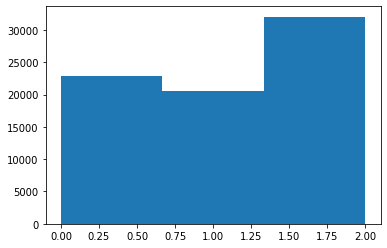

In [16]:
plt.hist(actions,bins = 3)

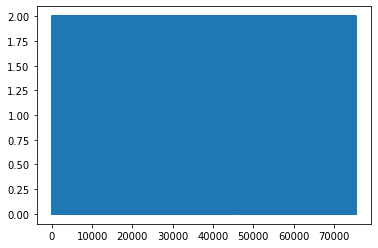

In [17]:
plt.plot(actions)

(array([ 4059.,  7428., 38513.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

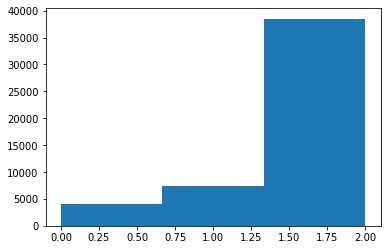

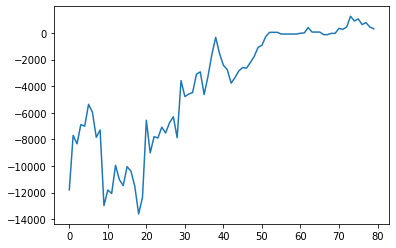

In [7]:
# plt.plot(score_history)
avg_scores = [np.mean(score_history[i:i+20]) for i in range(0, len(score_history)-20)]
plt.plot(avg_scores)